Import python modules and packages

In [25]:
from __future__ import division
import cobra
import copy
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import sample
import pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import stats
from numpy import array,empty
import six
from sympy import Add, Mul
from sympy.functions.elementary.miscellaneous import Max, Min
from statannot import add_stat_annotation
import pickle
import os.path
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from matplotlib_venn import venn3

Read in RNA-seq data.

The column "Sensitive" contains normalized RNA counts and the data for the rest columns are RNA counts relative to the "Sensitive" column.

Sensitive: D-3rsw + 0 azt; Sensitive_azt2: D-3rsw + 2 ug/ml azt; Resistant: D+7bld + 0 ug/ml azt; Resistant_azt2: D+7bld + 2 ug/ml azt; Resistant_azt4: D+7bld + 4 ug/ml azt. 

In [2]:
rna_counts = pd.read_csv('./input_data/counts_for_changes_in_expression_reference_S0.csv')
rna_counts.set_index('Pputida_geneID',inplace=True)
rna_counts.head()

,Sensitive,Sensitive_azt2,Resistant,Resistant_azt2,Resistant_azt4
Pputida_geneID,,,,,
PP_0026,91.588210,0.809509,0.936369,1.130332,0.992024
PP_0037,16.878464,1.089547,1.382828,1.341800,1.081017
PP_0043,38.590141,0.836627,0.766696,0.994692,0.977511
PP_0058,163.002706,0.942806,0.959654,0.895476,0.943103
PP_0059,255.811532,0.660732,0.943470,0.834243,0.744608


Setup uptake fluxes to mimic culture medium.

The casamino acids medium used in experiment contains all 20 amino acids except for tryptophan and essential micronutrients. For amino acids, we assume that their maximum uptake rates are all equal to 1 (in any unit). For micronutrients, we assume their uptake rates are unbounded (equal to 1000) and never become growth-limiting. Thus, all intracellular fluxes are normalized to the amino acid influx rates. 

In [3]:
def set_culture_medium(fraction_of_optimum):
    
    """
    Parameters
    ----------
    fraction_of_optimum: fraction of optimum for flux variability analysis
    """
    
    # read P. putida model deveoped by Nogales et al., 2017
    model = cobra.io.load_json_model('./input_data/SI3_iJN1411final_flux.json')
    
    # close all uptake reactions
    ex_rxns = [r for r in model.reactions if r.id.startswith('EX')]
    for r in ex_rxns:
        r.lower_bound = 0
    
    # reset lower bound of uptake fluxes for only nutrients in culture medium
    CAA_min_media = {
        
        # trace elements
        'EX_pi_e_'     : -1000,     # phosphate
        'EX_fe3_e_'    : -1000,     # fe3+
        'EX_mn2_e_'    : -1000,     # mn2+
        'EX_zn2_e_'    : -1000,     # zn2+
        'EX_cu2_e_'    : -1000,     # cu2+
        'EX_ca2_e_'    : -1000,     # ca2+
        'EX_cl_e_'     : -1000,     # cl-
        'EX_cobalt2_e_': -1000,     # cobalt2+
        'EX_k_e_'      : -1000,     # k+
        'EX_mg2_e_'    : -1000,     # mg2+
        'EX_mobd_e_'   : -1000,     # mo6+
        'EX_na1_e_'    : -1000,     # na+
        'EX_ni2_e_'    : -1000,     # ni2+
        'EX_o2_e_'     : -1000,     # o2
        
        # amino acids
        'EX_leu_L_e_'  : -1,      
        'EX_ile_L_e_'  : -1,
        'EX_pro_L_e_'  : -1,
        'EX_trp_L_e_'  :  0,        # no tryptophan
        'EX_met_L_e_'  : -1,
        'EX_cys_L_e_'  : -1,
        'EX_val_L_e_'  : -1,
        'EX_asp_L_e_'  : -1,
        'EX_asn_L_e_'  : -1,
        'EX_ser_L_e_'  : -1,
        'EX_thr_L_e_'  : -1,
        'EX_ala_L_e_'  : -1,
        'EX_arg_L_e_'  : -1,
        'EX_gly_e_'    : -1,
        'EX_his_L_e_'  : -1,
        'EX_lys_L_e_'  : -1,
        'EX_phe_L_e_'  : -1,
        'EX_gln_L_e_'  : -1,
        'EX_glu_L_e_'  : -1,
        'EX_tyr_L_e_'  : -1
    }
    for r in CAA_min_media.keys():
        try:
            rxn = model.reactions.get_by_id(r)
            rxn.lower_bound = CAA_min_media[r]
            rxn.upper_bound = 1000
        except:
            print("The reaction {} does not exist in model.".format(str(r)))
            continue;

    # flux variability analysis to determine min/max of flux bounds, 
    # given biomass flux is at least "fraction_of_optimum" of its maximum value
    fva=flux_variability_analysis(model,model.reactions,loopless=False, fraction_of_optimum=fraction_of_optimum)
    for r in model.reactions:
        r.lower_bound = fva['minimum'][r.id]
        r.upper_bound = fva['maximum'][r.id]
    
    return model, fva

In [4]:
unconstrained_model, _ = set_culture_medium(fraction_of_optimum=0.0)

Academic license - for non-commercial use only


In [5]:
unconstrained_model.slim_optimize() # the model predicts maximum biomass flux 1.44

1.4385686466787628

Determine flux bounds of the reference model (sensitive strain + 0 azt). 

The flux bounds of reactions in the reference model are approximated by the optimal flux solution that maximizes the consistency between gene expression and flux. The solution can be found by the iMAT algorithm (originally developed by Shlomi et al., Nature Biotechnology, Vol. 26, 2008), which is implemented in function imat.

For reactions associated with multiple isozymes or one enzyme with multiple subunits, we determined their corresponding transcription levels by replacing “and” and “or” operators with “min” and “max” respectively in their gene-protein-reaction (GPR) rules. This is implemented in function or2min_and2max.

In [11]:
def imat(expression_profile, reference, normalization, lowq=0.25, highq=0.75, epsilon=1,
         fraction_of_optimum=1.0, *args, **kwargs):
    """
    Parameters
    ----------
    expression_profile: gene expression profiles
    reference: reference condition (must be a column in the expression profile)
    normalization: function to process GPR rules if a reaction is associated with 
                   multiple isozymes or one enzyme with multiple subunits
    lowq: the quantile to calcualte cutoff value for low expression genes
    highq: the quantile to calculate cutoff value for high expression values
    epsilon: a positive threshold to determine active flux associated with highly expressed reactions
    fraction_of_optimum: biomass constraint requires that the ratio of biomass flux to its maximum possible value
                         must be equal or higher than "fraction_of_optimum"
    """
        
    model,_ = set_culture_medium(0.0)
    
    # builds a dict with genes as keys and the expression value for the selected sample.
    if reference == 'Sensitive':
        expression_values = expression_profile['Sensitive']
    else:
        expression_values = expression_profile[reference] * expression_profile['Sensitive']    
    gene_exp = dict(zip(expression_profile.index, expression_values))

    low_cutoff = np.quantile(expression_values, lowq, axis=0)
    high_cutoff = np.quantile(expression_values, highq, axis=0)
    
    # make a disctionary that mappes reaction id to associated gene expression
    reaction_profile = {}
    for r in model.reactions:
        
        # this is an important assumption:
        # we only constrain reactions using gene expression data when all associated genes can be
        # found in expression profiles. Since we used a P. putida model, only 80% genes in the model
        # are covered by our transcriptomics data
        
        if len(r.genes) > 0 and all([identifier.id in expression_profile.index for identifier in r.genes]):
            _, reaction_profile[r.id] = normalization(r, {g.id: gene_exp.get(g.id) for g in r.genes})
        
    y_variables = list()
    x_variables = list()
    constraints = list()
    
    # flux variance analysis
    fva_res = flux_variability_analysis(model, 
                                        list(reaction_profile.keys()), 
                                        fraction_of_optimum=fraction_of_optimum)
    
    for rid, expression in six.iteritems(reaction_profile):
        if expression == 0.0:
            # reactions shut down completely
            model.reactions.get_by_id(rid).lower_bound = 0
            model.reactions.get_by_id(rid).upper_bound = 0
        elif expression > high_cutoff:     
            reaction = model.reactions.get_by_id(rid)
            y_pos = model.solver.interface.Variable("y_%s_pos" % rid, type="binary")
            y_neg = model.solver.interface.Variable("y_%s_neg" % rid, type="binary")
            y_variables.append([y_neg, y_pos])
            pos_constraint = model.solver.interface.Constraint(
                reaction.flux_expression + y_pos * (fva_res["minimum"][rid] - epsilon),
                lb=fva_res["minimum"][rid], name="pos_highly_%s" % rid)  
            neg_constraint = model.solver.interface.Constraint(
                reaction.flux_expression + y_neg * (fva_res["maximum"][rid] + epsilon),
                ub=fva_res["maximum"][rid], name="neg_highly_%s" % rid)
            constraints.extend([pos_constraint, neg_constraint])
        elif expression < low_cutoff:
            reaction = model.reactions.get_by_id(rid)
            x = model.solver.interface.Variable("x_%s" % rid, type="binary")
            x_variables.append(x)

            pos_constraint = model.solver.interface.Constraint(
                (1 - x) * fva_res["maximum"][rid] - reaction.flux_expression,
                lb=0, name="x_%s_upper" % rid)
            neg_constraint = model.solver.interface.Constraint(
                (1 - x) * fva_res["minimum"][rid] - reaction.flux_expression,
                ub=0, name="x_%s_lower" % rid)
            constraints.extend([pos_constraint, neg_constraint])

    len_xy = 0
    for variable in x_variables:
        model.solver.add(variable)
        len_xy += 1

    for variables in y_variables:
        model.solver.add(variables[0])
        model.solver.add(variables[1])
        len_xy += 1

    for constraint in constraints:
        model.solver.add(constraint)

    model.objective = model.solver.interface.Objective(Add(*[(y[0] + y[1]) for y in y_variables]) + Add(*x_variables),
                                                       direction="max")
    solution = model.optimize()
    return model, solution, reaction_profile

In [12]:
def or2min_and2max(reaction, gene_values):
    
    """
    Parameters
    ----------
    reaction: reaction to be considered
    gene_values: a dict with gene ids as keys and their expression levels as values
    """
        
    gene_expression_array = reaction.gene_reaction_rule.split(' ')
    gene_expression_array = [x for x in gene_expression_array if x != '']
        
    # parse substrings from the innermost parenthesis until neither 'or' or 'and' is leftover
    while 'or' in gene_expression_array or 'and' in gene_expression_array:
                
        # find the inner most ( and )
        for i in range(len(gene_expression_array)):
            if gene_expression_array[i] == ')':
                # should be the first ')' in the array
                right_bracket_index = i
                break
        for i in range(len(gene_expression_array)):
            if gene_expression_array[i] == '(':
                # should be the last '(' before the first ')'
                left_bracket_index = i
            if i==right_bracket_index:
                break
                
        # parse the content of the innermost parenthesis
        parenthesis_content = gene_expression_array[left_bracket_index+1:right_bracket_index]
        
        gene_left_behind = ''
        if 'and' in ''.join(parenthesis_content):
            genes = ''.join(parenthesis_content).split('and')
            smallest_value = 1e10
            for g in genes:
                current_value = gene_values[g]
                if  current_value < smallest_value:
                    gene_left_behind = g
                    smallest_value = current_value
        elif 'or' in ''.join(parenthesis_content):
            genes = ''.join(parenthesis_content).split('or')
            largest_value = -1
            for g in genes:
                current_value = gene_values[g]
                if  current_value > largest_value:
                    gene_left_behind = g
                    largest_value = current_value
        else:
            assert len(parenthesis_content)==1
            gene_left_behind = parenthesis_content[0]

        # replace the entire content in the parenthesis with the gene_left_behind
        del gene_expression_array[left_bracket_index:right_bracket_index+1]
        gene_expression_array.insert(left_bracket_index, gene_left_behind)
                
    assert len(gene_expression_array)==1 
    return gene_expression_array[0], gene_values[gene_expression_array[0]]

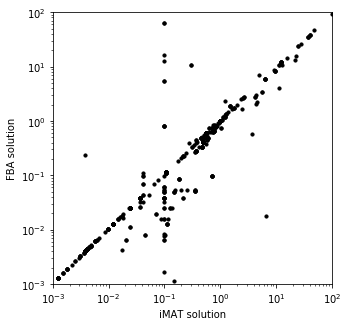

In [18]:
# Compare iMAT solution and solution of classical flux balance analysis (biomass objective function)

solution_fba = unconstrained_model.optimize()
model_imat95, solution_imat95, _ = imat(expression_profile=rna_counts,
                                        reference="Sensitive",
                                        normalization=or2min_and2max,
                                        lowq=0.25, 
                                        highq=0.75, 
                                        epsilon=0.1,
                                        fraction_of_optimum=0.95)

fba_flux = [np.abs(solution_fba.fluxes[r.id]) for r in unconstrained_model.reactions]
imat95_flux = [np.abs(solution_imat95.fluxes[r.id]) for r in unconstrained_model.reactions]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.scatter(imat95_flux, fba_flux, s=10, color='black')
ax.set_xlabel('iMAT solution')
ax.set_ylabel('FBA solution')
ax.set_xlim([0.001,100])
ax.set_ylim([0.001,100])
ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

Build metabolic models for the reference and other conditions

Metabolic models in the reference condition were constructed by constraining reactions using iMAT solution.

Metabolic models in other conditions were constructed by modifying the flux bounds of reactions in the reference model based on gene expression changes between these conditions and the reference condition, i.e., v_(min,i)→v_(min,i)∙c_i, v_(max,i)→v_(max,i)∙c_i, where c_i is the fold change in mRNA levels of genes associated with reaction i.

In [19]:
def build_metabolic_model(model, iMAT_solution, expression_profile, condition, normalization=or2min_and2max):
 
    """
    Parameters
    ----------
    model: the original iJN1411 model
    iMAT_solution: iMAT flux solution to constrain reference model
    expression_profile: gene expression profiles
    condition: condition under consideration
    normalization: function to process GPR rules if a reaction is associated with 
                   multiple isozymes or one enzyme with multiple subunits
    """

    if condition != 'Sensitive':
        expression_values = expression_profile[condition] * expression_profile['Sensitive']
        gene_exp = dict(zip(expression_profile.index, expression_values)) # abosolute value
    
    for r in model.reactions:
        if condition != 'Sensitive':
            if len(r.genes) > 0 and all([identifier.id in expression_profile.index for identifier in r.genes]):
                gid, _ = normalization(r, {g.id: gene_exp.get(g.id) for g in r.genes})
                to_constrain = iMAT_solution[r.id] * expression_profile.loc[gid,condition]
            else:
                to_constrain = iMAT_solution[r.id]
        else:
            to_constrain = iMAT_solution[r.id]
            
        if to_constrain == 0.0:
            r.lower_bound=to_constrain
            r.upper_bound=to_constrain
        elif to_constrain < 0.0:
            r.lower_bound=to_constrain
            
            # remove reversibility
            if r.upper_bound>0.0:
                r.upper_bound=0.0
        else:
            r.upper_bound=to_constrain
            
            # remove reversibility
            if r.lower_bound<0.0:
                r.lower_bound=0.0
        
    return model

In [109]:
# Warning: sampling the solution space for 100,000 times will take dozens of minutes to one hour. 

constrained_models = {} # models constrained by gene expression data
flux_samples = {} # sampling flux solution space of constrained models

conditions=['Sensitive','Sensitive_azt2','Resistant','Resistant_azt2','Resistant_azt4']
for cond in conditions:
         
    # construct model
    print('building model for condition: %s'%(cond))
    unconstrained_model_copy = copy.deepcopy(unconstrained_model)
    model = build_metabolic_model(model=unconstrained_model_copy, 
                                  iMAT_solution=solution_imat95,
                                  expression_profile=rna_counts,
                                  condition=cond)
    constrained_models.update({cond: model})
    
    # sample the flux space
    print('sampling solution space for condition-specific model (condition = %s)'%(cond))
    s = sample(model, 100000, processes=12)
    flux_samples.update({cond : s})

# consider save the variables to file so that you can load them next time without running from scratch
# write variables:
# pickle.dump(constrained_models, open("./output_data/constrained_models.p", "wb"))
# pickle.dump(flux_samples, open("./output_data/flux_samples.p", "wb"))
# load variables:
# constrained_models = pickle.load(open("./output_data/constrained_models.p","rb"))
# flux_samples = pickle.load(open("./output_data/flux_samples.p","rb"))

building model for condition: Sensitive
Read LP format model from file /var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/tmpucyeos_7.lp
Reading time = 0.02 seconds
: 2087 rows, 5652 columns, 22456 nonzeros
sampling solution space for condition-specific model (condition = Sensitive)
Read LP format model from file /var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/tmpft_4b4t1.lp
Reading time = 0.01 seconds
: 2087 rows, 5652 columns, 22456 nonzeros
building model for condition: Sensitive_azt2
Read LP format model from file /var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/tmp5m7yjfyv.lp
Reading time = 0.02 seconds
: 2087 rows, 5652 columns, 22456 nonzeros
sampling solution space for condition-specific model (condition = Sensitive_azt2)
Read LP format model from file /var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/tmp6u23viye.lp
Reading time = 0.02 seconds
: 2087 rows, 5652 columns, 22456 nonzeros
building model for condition: Resistant
Read LP format model from file /var/folders/zg/9bd_wdgn3

Comparison of predicted relative growth rate with experimental data.

We used bootstraap resampling method to compute distribution of relative growth rate across conditions, namely, R0 vs. S0, S2 vs. S0, R2 vs. R0, R4 vs. R0. 

S0: sensitive strain + 0 azt; S2: sensitive strain + 2 azt; R0: resistant strain + 0 azt; R2: resistant strain + 2 azt; R4: resistant strain + 4 azt.

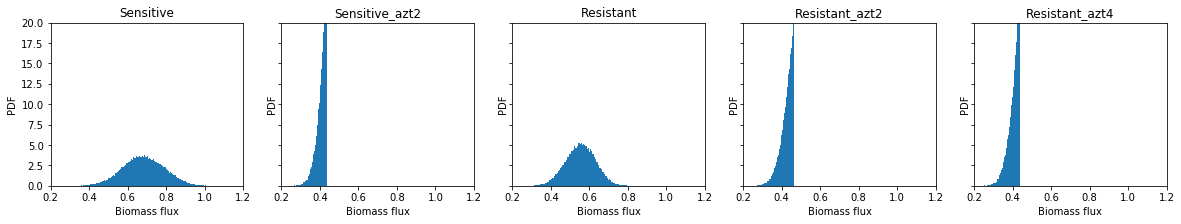

In [161]:
# Show distribution of biomass flux

fig, ax = plt.subplots(1,5,sharex=True,sharey=True)
fig.set_size_inches(20,3)

conditions=['Sensitive','Sensitive_azt2','Resistant','Resistant_azt2','Resistant_azt4']
for index_c, cond in enumerate(conditions):
    ax[index_c].hist(flux_samples[cond]['BiomassKT2440_WT3'],bins=200, density=True)
    ax[index_c].set_ylabel('PDF')
    ax[index_c].set_xlabel('Biomass flux')
    ax[index_c].set_xlim([0.2,1.2])
    ax[index_c].set_ylim([0,20])
    ax[index_c].set_title(cond)
    
plt.show()
fig.savefig('./output_data/biomass_flux_distribution.svg', format='svg', dpi=1200)

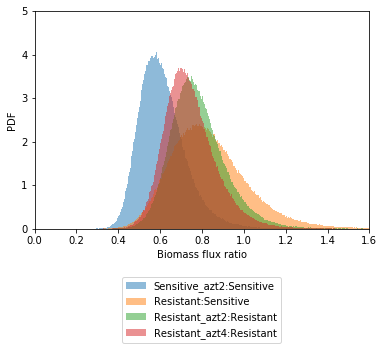

In [121]:
# Compute distribution of relative growth rate

n_rs = 1000000          # number of resamples
ratio_distribution = {} # distribution
biomass_flux_mean  = {} # mean
biomass_flux_std   = {} # standard deviation

ref  = ['Sensitive',      'Sensitive', 'Resistant',      'Resistant']
cond = ['Sensitive_azt2', 'Resistant', 'Resistant_azt2', 'Resistant_azt4']
for r,c in zip(ref, cond):
    rd = np.random.choice(flux_samples[c]['BiomassKT2440_WT3'],n_rs)/np.random.choice(flux_samples[r]['BiomassKT2440_WT3'],n_rs)
    ratio_distribution.update({c: rd})
    biomass_flux_mean.update({c: np.mean(rd)})
    biomass_flux_std.update({c: np.std(rd,ddof=1)})
        
# plot
fig=plt.figure(figsize=(6,4))
bins = np.linspace(0, 2, 1000)
for r,c in zip(ref, cond):
    plt.hist(ratio_distribution[c], bins, density=True, alpha=0.5, label=c+':'+r)

plt.xlim([0,1.6])
plt.ylim([0,5.0])
plt.xlabel('Biomass flux ratio')
plt.ylabel('PDF')
plt.legend(bbox_to_anchor=(0.75, -0.2))
plt.show()
fig.savefig('./output_data/biomass_flux_ratio_distribution.svg', format='svg', dpi=1200)

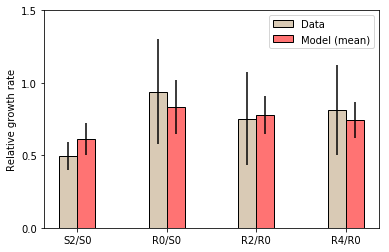

In [122]:
# Comparison of model prediction with experimental data

# Experiment measurement of growth rates were obtained elsewhere by fitting an exponential growth model
# the order of array elements are: S2/S0, R0/S0, R2/R0, R4/R0
RelGrate_mean_exp = [0.4940, 0.9391, 0.7532, 0.8128] # mean 
RelGrate_std_exp  = [0.0972, 0.3605, 0.3217, 0.3082] # standard deviation

# Model predicted values
RelGrate_mean_model = [biomass_flux_mean[c] for c in cond]
RelGrate_std_model  = [biomass_flux_std[c] for c in cond]

fig=plt.figure(figsize=(6,4))
barWidth = 0.2 # width of the bars

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]
r3 = [x + 2.0*barWidth for x in r1]
xpos_label = [x + 0.5*barWidth for x in r1]
 
plt.bar(r1, RelGrate_mean_exp, width = barWidth, yerr = RelGrate_std_exp, color = '#d9cab5', edgecolor = 'black',label='Data')
plt.bar(r2, RelGrate_mean_model, width = barWidth, yerr = RelGrate_std_model, color = '#ff7373', edgecolor = 'black',label='Model (mean)')

plt.xticks(xpos_label, ['S2/S0','R0/S0','R2/R0','R4/R0'])
plt.ylabel('Relative growth rate')
plt.ylim([0,1.5])
plt.yticks([0,0.5,1.0,1.5])
plt.legend()

plt.show()
fig.savefig('./output_data/relative_growth_rate_experiment_model_comparison.svg', format='svg', dpi=1200)

Show relative flux changes across conditions in a clustermap.

For each reaction, its relative flux change between two conditions is calculated as the ratio of median flux in these conditions. To avoid "divided-by-zero" error, we consider only reactions whose absolute flux value in the reference condition is above a flux threshold.

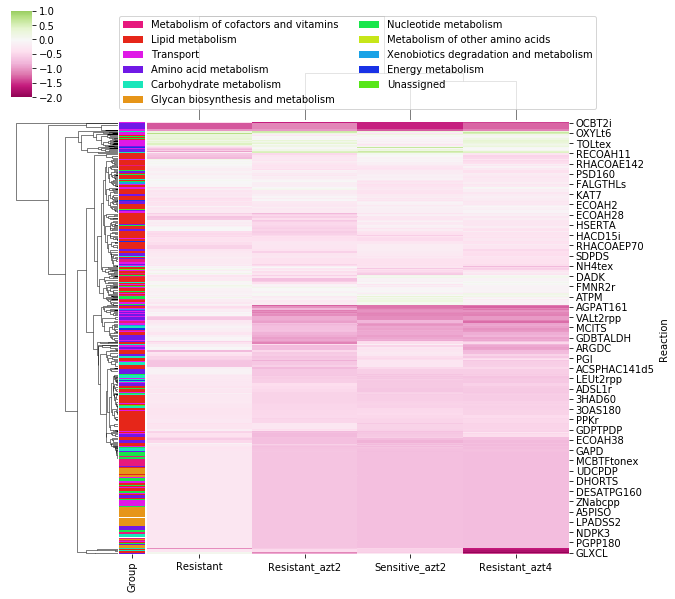

In [145]:
# To understand overall flux changes in specific pathways, we mapped the subsytem of each reaction 
# to one of the following 12 groups. See https://manet.illinois.edu/pathways.php for details

groups = ['Metabolism of cofactors and vitamins',
          'Lipid metabolism',
          'Transport',
          'Amino acid metabolism',
          'Carbohydrate metabolism',
          'Glycan biosynthesis and metabolism',
          'Nucleotide metabolism',
          'Metabolism of other amino acids',
          'Xenobiotics degradation and metabolism',
          'Energy metabolism',
          'Unassigned']

rule_of_subsystem_group_mapping = { 
    '':'Unassigned',            
    # Most of the reactions of this subsystem belong to transport reactions of inorganic ions
    # so a better description may be "Inorganic Ion Transport and Metabolism"
    'S_Heavy_Metal_Tolerance':'Transport',
    'S_Arginine_and_Proline_Metabolism':'Amino acid metabolism',
    'S_Urea_cycleamino_group_metabolism':'Amino acid metabolism',
    'S_Glycerophospholipid_Metabolism':'Lipid metabolism',
    # Reactions not found in Bigg Database
    # Hydroxy-L-proline belongs to arginine and proline metabolism
    'S_Alternate_Carbon_and_Nitrogen_source__Hydroxy_proline_metabolism':'Amino acid metabolism',
    # AMPTASECG belongs to Cysteine Metabolism (glutationine metabolism by Kegg, Metabolism of other amino acids) 
    # AMPTASEPG not found in Kegg, but labelled as arginine and proline metabolism in Bigg
    # APATr,MMSAD3 belongs to beta-alanine metabolism (Metabolism of other amino acids)
    # LALGP is labled for murin biosynthesis
    # Just pick one
    'S_Alternate_Carbon_and_Nitrogen_source__Dipeptide_Metabolism':'Metabolism of other amino acids',
    'S_Cysteine_Metabolism':'Amino acid metabolism',
    # HPYRRy belongs to glycine, serine, threonine metabaolism
    # ACONMT, ACONIs belongs to unassigned (no associated class in KEGG)
    'S_Alternate_Carbon':'Carbohydrate metabolism',
    # DAAD was associated with alanine and aspartate metabolism in Bigg
    # UNK3 was associated with cystein and mathionine metabolism in Bigg
    # But D-Glutamine, D-glutamate, D-Arginine, D-ornithine, and D-Alanine metabolisms belong to Metabolism of other amino acids
    'S_Alternate_Carbon_and_Nitrogen_source__D_Amino_acids_Metabolism':'Metabolism of other amino acids',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__One_Carbon_pool_by_folate':'Metabolism of cofactors and vitamins',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Pantothenate_and_CoA_Biosynthesis':'Metabolism of cofactors and vitamins',
    'S_Alanine_and_Aspartate_Metabolism':'Amino acid metabolism',
    'S_Pentose_Phosphate_Pathway':'Carbohydrate metabolism',
    'S_Alternate_Carbon__Propanoate_Metabolism':'Carbohydrate metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Ubiquinone_biosynthesis':'Metabolism of cofactors and vitamins',
    # No reactions found in KEGG
    'S_Aromatic_Compounds_Degradation__Gallic_acid_Metabolism':'Unassigned',
    'S_Oxidative_Phosphorylation':'Energy metabolism',
    # No reactions found in KEGG
    'S_Alternate_Carbon__Butanediol_Metabolism':'Carbohydrate metabolism',
    'S_Aromatic_Compounds_Degradation__Toluene_Pathway':'Xenobiotics degradation and metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Biotin_Biosynthesis':'Metabolism of cofactors and vitamins',
    # Some reactions not found in KEGG, others belong to purine and pyramidine metabolisms
    'S_Alternate_Carbon_and_Nitrogen_source__Nucleotide_Metabolism':'Nucleotide metabolism',
    # Reactions starting with ALG not found in Bigg. Others belong to fructose and mannonse metabolism
    'S_Alginate_biosynthesis':'Carbohydrate metabolism',
    # DDGLK belongs to Pentose phosphate pathway
    # ALTRH belongs to Pentose and glucuronate interconversions
    # GLCRD belongs to Ascorbate and aldarate metabolism
    # All these pathways are grouped as carbohydrate metabolism
    'S_Alternate_Carbon__Ascorbate_and_Aldarate_Metabolism':'Carbohydrate metabolism',
    'S_Fatty_Acid_Metabolism':'Lipid metabolism',
    'S_Starch_and_Sucrose_Metabolism':'Carbohydrate metabolism',
    # Reactions not found in Bigg
    'S_Xenobiotic_tolerance':'Xenobiotics degradation and metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis___Pyrroloquinoline_quinone_biosynthesis':'Metabolism of cofactors and vitamins',
    'S_Histidine_Metabolism':'Amino acid metabolism',
    'S_PHAs_Metabolism':'Lipid metabolism',
    'S_Glyoxylate_and_dicarboxylate_metabolism':'Carbohydrate metabolism',
    'S_':'Unassigned',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Thiamine_Metabolism':'Metabolism of cofactors and vitamins',
    'S_Nitrogen_Metabolism':'Energy metabolism',
    # Reactions not found in KEGG
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__FeS_clusters_metabolism':'Metabolism of cofactors and vitamins',
    'S_Butanoate_Metabolism':'Carbohydrate metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Porphyrin_and_Chlorophyll_Metabolism':'Metabolism of cofactors and vitamins',
    'S_tRNA_Charging':'Translation',
    'S_Transport__Outer_Membrane':'Transport',
    # PPK associated with oxidative phosphorylation
    'S_Inorganic_polyphosphates_metabolism':'Energy metabolism',
    'S_Lysine_Biosynthesis':'Amino acid metabolism',
    'S_Methionine_Metabolism':'Amino acid metabolism',
    'S_Lysine_Metabolism':'Amino acid metabolism',
    'S_Valine__leucine_and_isoleucine_degradation':'Amino acid metabolism',
    'S_Cell_Envelope_Biosynthesis__LPS_Biosynthesis':'Glycan biosynthesis and metabolism', # Lipopolysaccharide biosynthesis
    'S_Valine__Leucine__and_Isoleucine_Metabolism':'Amino acid metabolism',
    # BZDIOLDH belongs to benzoate degradation
    # VNTDM belongs to aminobenzoate degradation
    # 3OXCOAT belongs to amino acid metabolism
    'S_Aromatic_Compounds_Degradation__B_Ketoadipate_pathway':'Amino acid metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Vitamin_B6_Metabolism':'Metabolism of cofactors and vitamins',
    'S_Methionine_Metabolism_':'Amino acid metabolism',
    'S_Phosphonate_and_phosphinate_metabolism':'Metabolism of other amino acids',
    'S_Gluconeogenesis':'Carbohydrate metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Molybdopterin_Biosynthesis':'Metabolism of cofactors and vitamins',
    'S_Glycolysis':'Carbohydrate metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Terpenoid_backbone_biosynthesis':'Metabolism of cofactors and vitamins',
    'S_Purine_Metabolism':'Nucleotide metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Queuosine_biosynthesis':'Metabolism of cofactors and vitamins',
    'S_Pyrimidine_Metabolism':'Nucleotide metabolism',
    'S_Transport__Inner_Membrane':'Transport',
    'S_Alternate_Carbon__Fructose_Metabolism':'Carbohydrate metabolism',
    'S_Cell_Envelope_Biosynthesis__O_antigen_Biosynthesis':'Glycan biosynthesis and metabolism',
    # 3 out of 4 reactions belong to tryptophan metabolism
    'S_Plant_growth_promoting':'Amino acid metabolism',
    'S_Cell_Envelope_Biosynthesis__Cellulose_Metabolism':'Carbohydrate metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Folate_Biosynthesis':'Metabolism of cofactors and vitamins',
    'S_Cell_Envelope_Biosynthesis':'Glycan biosynthesis and metabolism',
    'S_Transport__ABC_system':'Transport',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis':'Metabolism of cofactors and vitamins',
    # FMNRx belongs to Riboflavin metabolism (Metabolism of cofactors and vitamins)
    # Many of reactions cannot be found in Bigg or Kegg
    'S_Iron_uptake_and_metabolism':'Metabolism of cofactors and vitamins',
    # Reactions not found in Bigg
    'S_Alternate_Carbon_and_Nitrogen_source__Ectoine_Metabolism':'Unassigned',
    'S_Sulfur_Metabolism':'Energy metabolism', # yes, checked
    'S_Glutamate_Metabolism':'Amino acid metabolism',
    # ALDD1 belongs to Chloroalkane and chloroalkene degradation (Xenobiotics degradation and metabolism)
    # FALDH2 belongs to Methane metabolism in Energy metabolism
    # FDH belongs to both Glyoxylate and dicarboxylate metabolism (carbohydrate metabolism) or methane metabolism
    'S_Formaldehyde_Metabolism':'Xenobiotics degradation and metabolism',
    'S_Glycine__Serine_and_threonine_metabolism':'Amino acid metabolism',
    'S_Unassigned':'Unassigned',
    'S_Pyruvate_Metabolism':'Carbohydrate metabolism',
    'S_Cell_Envelope_Biosynthesis__Peptidoglycan_Biosynthesis':'Glycan biosynthesis and metabolism',
    'S_Aromatic_Compounds_Degradation__Nicotinic_acid_pathway':'Metabolism of cofactors and vitamins',
    'S_Phenylalanine_Tyrosine_Tryptophan_Biosynthesis':'Amino acid metabolism',
    'S_Cell_Envelope_Biosynthesis__Lipid_A_Biosynthesis':'Glycan biosynthesis and metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Riboflavin_Metabolism':'Metabolism of cofactors and vitamins',
    'S_Nucleotide_Salvage_Pathway':'Nucleotide metabolism',
    # ABUTD belongs to arginine and proline metabolism
    # The first pathway associated with putrescine is also arginine and proline metabolism
    'S_Alternate_Carbon_and_Nitrogen_source__Amines_and_Polyamines_Metabolism':'Amino acid metabolism',
    # PACCOAL is associated with phenylalanine metabolism
    'S_Aromatic_Compounds_Degradation__Phenylacetyl_CoA_Catabolom':'Amino acid metabolism',
    'S_TCA_Cycle':'Carbohydrate metabolism',
    # The first pathway associated with Homogentisate is Ubiquinone and other terpenoid-quinone biosynthesis
    # (Metabolism of cofactors and vitamins)
    'S_Aromatic_Compounds_Degradation__Homogentisate_pathway':'Metabolism of cofactors and vitamins',
    'S_Cell_Envelope_Biosynthesis__Biosynthesis_of_L_glycero_D_manno_heptose__Hep_':'Glycan biosynthesis and metabolism', # checked
    'S_Fatty_Acid__Biosynthesis':'Lipid metabolism',
    'S_Transport__solvent_extrusion':'Transport',
    'S_Alanine_and_Aspartate_Metabolism_':'Amino acid metabolism',
    # R15BPK belongs to pentose phosphate pathway
    # Other reactions not found in Kegg
    'S_Alternate_Carbon__Ribose_Metabolism':'Carbohydrate metabolism',
    'S_Cofactor_and_Prosthetic_Group_Biosynthesis__Nicotinamide_Biosynthesis':'Metabolism of cofactors and vitamins'
}
   
# Compute relative flux changes
conditions = ['Sensitive_azt2','Resistant','Resistant_azt2','Resistant_azt4']
flux_threshold = 1e-3

relative_flux_change = []
for r in unconstrained_model.reactions:
    if r.subsystem == 'S_': # exclude reactions labeled with subsystem 'S_', which are mostly exchange reactions "EX_" 
        continue
        
    res = {'Reaction':r.id}
    res.update({'Subsystem':r.subsystem})
    res.update({'Group':rule_of_subsystem_group_mapping[r.subsystem]})
    
    # a flux is inactive if it is below flux_threshold in all conditions
    if np.abs(flux_samples['Sensitive'][r.id].median()) > flux_threshold:
        for cond in conditions:
            s1=flux_samples[cond]
            s2=flux_samples['Sensitive']
            p1 = s1[r.id]
            p2 = s2[r.id]
            res.update({cond:np.log2(p1.median()/(p2.median()))})
        relative_flux_change.append(res)
            
relative_flux_change = pd.DataFrame(relative_flux_change)
relative_flux_change.set_index('Reaction',inplace=True)

# plot relative flux change in a clustermap
lut = dict(zip(set(groups), sns.hls_palette(len(set(groups)), l=0.5, s=0.8))) # l: lightness, s: saturation
row_colors = relative_flux_change['Group'].map(lut)
to_plot = relative_flux_change[['Sensitive_azt2','Resistant','Resistant_azt2','Resistant_azt4']]
g=sns.clustermap(to_plot, 
                 cmap='PiYG',
                 row_colors=row_colors,
                 row_cluster=True,
                 vmin=-2.0,
                 vmax=1.0,
                 center=0,
                 robust=True,
                 metric='cityblock',
                 method='average')
for label in groups:
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="upper center", ncol=2)
g.savefig('./output_data/relative_flux_change_clustermap.svg', format='svg', dpi=1200)

In [146]:
# How many reactions are present in each group?
print('Total number of active reactions: %d'%(len(relative_flux_change.index)))
for g in groups:
    print(g, relative_flux_change['Group'].tolist().count(g))

Total number of active reactions: 844
Metabolism of cofactors and vitamins 49
Lipid metabolism 318
Transport 117
Amino acid metabolism 142
Carbohydrate metabolism 62
Glycan biosynthesis and metabolism 62
Nucleotide metabolism 61
Metabolism of other amino acids 1
Xenobiotics degradation and metabolism 6
Energy metabolism 16
Unassigned 8


In [148]:
# What is the percentage of reactions that are up- and down-regulated 
# with aboslute log2 flux change > 0.5 in each condition?
for cond in conditions:
    x = relative_flux_change[cond]
    percent_up = len(x[x>0.5])/len(relative_flux_change.index) * 100
    percent_down = len(x[x<-0.5])/len(relative_flux_change.index) * 100
    print('%s: upregulated (%2.2f%%), downregulated(%2.2f%%)'%(cond, percent_up, percent_down))

Sensitive_azt2: upregulated (0.71%), downregulated(51.78%)
Resistant: upregulated (0.24%), downregulated(11.14%)
Resistant_azt2: upregulated (0.71%), downregulated(54.86%)
Resistant_azt4: upregulated (0.71%), downregulated(56.28%)


Calculate significant flux changes between conditions, using three cutoff criteria (1) adjusted p-value < 0.05; (2) absolute log2-fold change >= 0.5; (3) absolute flux value > 1e-3

In [149]:
def multiple_testing_correction(pvalues, correction_type):
    pvalues = array(pvalues)
    sample_size = pvalues.shape[0]
    qvalues = empty(sample_size)
    if correction_type == "Bonferroni":
        # Bonferroni correction
        qvalues = sample_size * pvalues
    elif correction_type == "Bonferroni-Holm":
        # Bonferroni-Holm correction
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
        values.sort()
        for rank, vals in enumerate(values):
            pvalue, i = vals
            qvalues[i] = (sample_size-rank) * pvalue
    elif correction_type == "FDR":
        # Benjamini-Hochberg, AKA - FDR test
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
        values.sort()
        values.reverse()
        new_values = []
        for i, vals in enumerate(values):
            rank = sample_size - i
            pvalue, index = vals
            new_values.append((sample_size/rank) * pvalue)
        for i in range(0, int(sample_size)-1):
            if new_values[i] < new_values[i+1]:
                new_values[i+1] = new_values[i]
        for i, vals in enumerate(values):
            pvalue, index = vals
            qvalues[index] = new_values[i]
    return qvalues

In [150]:
def flux_comparison(flux_samples, reference, condition, eps_pv, eps_fc, eps_flux):
          
    """
    Parameters
    ----------
    flux_samples: flux samples
    reference: reference condition
    condition: condition under consideration
    eps_pv: cutoff value for p-value
    eps_fc: cutoff value for fold change
    eps_flux: cutoff value for flux
    """
    res = []    
    for r in unconstrained_model.reactions:
        if r.subsystem == 'S_':
            continue   
        if np.abs(flux_samples[reference][r.id].median()) > eps_flux:
            p1 = flux_samples[condition][r.id]
            p2 = flux_samples[reference][r.id]
            p1_median = p1.median()
            p2_median = p2.median()
            stat, pval = stats.ks_2samp(p1,p2)
            res.append({'Reaction':r.id, 
                        'Subsystem':r.subsystem,
                        'Group':rule_of_subsystem_group_mapping[r.subsystem],
                        'Log2_fc':np.log2(p1_median/(p2_median)), 
                        'pval':pval})    
    res = pd.DataFrame(res)
    res['pval'] = multiple_testing_correction(res['pval'], correction_type="FDR")
    res.set_index('Reaction',inplace=True)
    res = res[(res['pval'] < eps_pv) &
              ((res['Log2_fc']>=eps_fc) | (res['Log2_fc']<=-eps_fc))]
    return res

In [151]:
# compute significant flux changes
significant_flux_change = {}
conditions = ['Resistant','Resistant_azt2','Resistant_azt4','Sensitive_azt2']
for cond in conditions:
    res = flux_comparison(flux_samples=flux_samples,
                          reference='Sensitive',
                          condition=cond,
                          eps_pv = 0.05,
                          eps_fc = 0.5,
                          eps_flux = 1e-3)
    significant_flux_change[cond] = res

Draw Venn diagram to show the relationships between aztreonam effect, mutation effect, and their combinatorial effect

Aztreonam effect: significant flux changes between sensitive at 0 and sensitive at 2
Mutation effect: significant flux changes between sensitive at 0 and resistant at 0
Combination effect: significant flux changes between sensitive at 0 and resistant at 2, 4

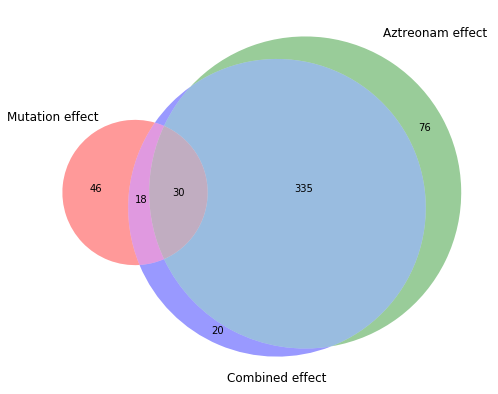

In [152]:
# aztreonam effect
x = significant_flux_change['Sensitive_azt2']
azt_upregulated   = set(x[x['Log2_fc']>=0.5].index.tolist())
azt_downregulated = set(x[x['Log2_fc']<=-0.5].index.tolist())
azt_effects       = set(x.index.tolist())

# mutation effect
x = significant_flux_change['Resistant']
mutation_upregulated   = set(x[x['Log2_fc']>=0.5].index.tolist())
mutation_downregulated = set(x[x['Log2_fc']<=-0.5].index.tolist())
mutation_effects       = set(x.index.tolist())

# combined effect
x = significant_flux_change['Resistant_azt2']
y = significant_flux_change['Resistant_azt4']
combined_upregulated = set(x[x['Log2_fc']>=0.5].index.tolist()).intersection(set(y[y['Log2_fc']>=0.5].index.tolist()))
combined_downregulated = set(x[x['Log2_fc']<=-0.5].index.tolist()).intersection(set(y[y['Log2_fc']<=-0.5].index.tolist()))
combined_effects = set(x.index.tolist()).intersection(y.index.tolist())

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,7)
v=venn3(subsets = (len(mutation_effects.difference(azt_effects).difference(combined_effects)),
                   len(azt_effects.difference(mutation_effects).difference(combined_effects)),
                   len(mutation_effects.intersection(azt_effects).difference(combined_effects)),
                   len(combined_effects.difference(mutation_effects).difference(azt_effects)),
                   len(mutation_effects.intersection(combined_effects).difference(azt_effects)),
                   len(azt_effects.intersection(combined_effects).difference(mutation_effects)),
                   len(azt_effects.intersection(combined_effects).intersection(mutation_effects))), 
        set_labels = ('Mutation effect', 'Aztreonam effect', 'Combined effect'))
plt.show()
fig.savefig('./output_data/venn_diagram_azt_mutation.svg', format='svg', dpi=1200)

The 48 reactions in the intersection of mutation effects and combined effects are constitutively modulated by mutations, as they occur regardless of the presence and concentration of aztreonam. Among the 48 reactions, 30 are also affected by aztreonam.

In [153]:
# 30 constitutive responses also affected by aztreonam
constitutive_responses_affected_by_azt = azt_effects.intersection(mutation_effects).intersection(combined_effects)

df_30 = []
for rid in constitutive_responses_affected_by_azt:
    r = unconstrained_model.reactions.get_by_id(rid)
    res = {'Name':r.id,
           'Subsystem':r.subsystem,
           'Pathway':rule_of_subsystem_group_mapping[r.subsystem],
           'Log2(S2/S0)':relative_flux_change.loc[r.id,'Sensitive_azt2'],
           'Log2(R0/S0)':relative_flux_change.loc[r.id,'Resistant'],
           'Log2(R2/S0)':relative_flux_change.loc[r.id,'Resistant_azt2'],
           'Log2(R4/S0)':relative_flux_change.loc[r.id,'Resistant_azt4'],
           'Reaction':r.reaction,
           'Affected by azt?': False}
    df_30.append(res)

df_30 = pd.DataFrame(df_30)
df_30 = df_30[['Name','Reaction','Subsystem','Pathway',
               'Log2(S2/S0)','Log2(R0/S0)','Log2(R2/S0)','Log2(R4/S0)']]
df_30.to_excel('./output_data/constitutive_responses_affected_by_azt.xlsx', sheet_name='sheet1', index=False)
df_30.head()

,Name,Reaction,Subsystem,Pathway,Log2(S2/S0),Log2(R0/S0),Log2(R2/S0),Log2(R4/S0)
0,RHACOAR140,3otdcoa_c + h_c + nadph_c <=> R_3hmrscoa_c + n...,S_PHAs_Metabolism,Lipid metabolism,-0.760747,-0.676120,-0.989669,-0.646884
1,3OXCOAT,coa_c + oxadpcoa_c --> accoa_c + succoa_c,S_Aromatic_Compounds_Degradation__B_Ketoadipat...,Amino acid metabolism,-1.572834,-1.324065,-1.087016,-1.262825
2,PPCSCT,ppcoa_c + succ_c --> ppa_c + succoa_c,S_Alternate_Carbon,Carbohydrate metabolism,-0.506563,-1.039087,-0.604751,-1.623402
3,HACD33i,3hdec4coa_c + nad_c --> 3odec4coa_c + h_c + na...,S_Fatty_Acid_Metabolism,Lipid metabolism,-0.738365,-0.582661,-0.712167,-0.712180
4,ALAtex,ala_L_e --> ala_L_p,S_Transport__Outer_Membrane,Transport,-0.686498,-0.505473,-0.746739,-0.538716


In [154]:
# 18 constitutive responses not affected by aztreonam
constitutive_responses_unaffected_by_azt = mutation_effects.intersection(combined_effects).difference(azt_effects)

df_18 = []
for rid in constitutive_responses_unaffected_by_azt:
    r = unconstrained_model.reactions.get_by_id(rid)
    res = {'Name':r.id,
           'Subsystem':r.subsystem,
           'Pathway':rule_of_subsystem_group_mapping[r.subsystem],
           'Log2(S2/S0)':relative_flux_change.loc[r.id,'Sensitive_azt2'],
           'Log2(R0/S0)':relative_flux_change.loc[r.id,'Resistant'],
           'Log2(R2/S0)':relative_flux_change.loc[r.id,'Resistant_azt2'],
           'Log2(R4/S0)':relative_flux_change.loc[r.id,'Resistant_azt4'],
           'Reaction':r.reaction,
           'Affected by azt?': False}
    df_18.append(res)

df_18 = pd.DataFrame(df_18)
df_18 = df_18[['Name','Reaction','Subsystem','Pathway',
               'Log2(S2/S0)','Log2(R0/S0)','Log2(R2/S0)','Log2(R4/S0)']]
df_18.to_excel('./output_data/constitutive_responses_unaffected_by_azt.xlsx', sheet_name='sheet1', index=False)
df_18.head()

,Name,Reaction,Subsystem,Pathway,Log2(S2/S0),Log2(R0/S0),Log2(R2/S0),Log2(R4/S0)
0,EDA,2ddg6p_c --> g3p_c + pyr_c,S_Glycolysis,Carbohydrate metabolism,-0.301087,-0.654043,-0.640075,-0.570576
1,RHACOARP40,3opbcoa_c + h_c + nadph_c --> R_3hpbcoa_c + na...,S_PHAs_Metabolism,Lipid metabolism,-0.279005,-0.665136,-0.558522,-0.548300
2,PGMT,g1p_c <-- g6p_c,S_Starch_and_Sucrose_Metabolism,Carbohydrate metabolism,-0.431686,-0.532282,-0.658120,-0.631595
3,PGI,g6p_c <-- f6p_c,S_Glycolysis,Carbohydrate metabolism,-0.431686,-0.532282,-0.658120,-0.631595
4,GLCDpp,glc_D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c,S_Glycolysis,Carbohydrate metabolism,-0.301087,-0.654043,-0.640075,-0.570576


In [157]:
# write reaction formula and metabolite name to excel file
metabolites_info = []
for rid in constitutive_responses_affected_by_azt:
    r = unconstrained_model.reactions.get_by_id(rid)
    for m in r.metabolites:
        res = {'Identifier': m.id,
               'Name': (' ').join(m.name.split('_')[1:][:-1]),
               'Formula': m.name.split('_')[-1]}
        metabolites_info.append(res)  
for rid in constitutive_responses_unaffected_by_azt:
    r = unconstrained_model.reactions.get_by_id(rid)
    for m in r.metabolites:
        res = {'Identifier': m.id,
               'Name': (' ').join(m.name.split('_')[1:][:-1]),
               'Formula': m.name.split('_')[-1]}
        metabolites_info.append(res)   
        
metabolites_info = pd.DataFrame(metabolites_info).drop_duplicates()
metabolites_info = metabolites_info[['Identifier','Name','Formula']]
metabolites_info.head()
metabolites_info.to_excel('./output_data/metabolites_information.xlsx', sheet_name='sheet1', index=False)

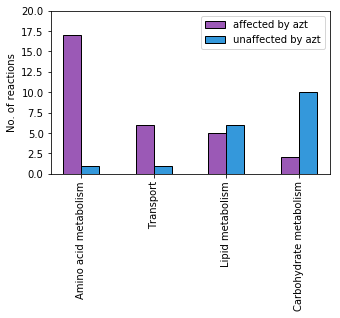

In [159]:
# How these reactions distributed across pathways?
counts_affected_by_azt = {}
counts_unaffected_by_azt = {}
for rid in constitutive_responses_affected_by_azt:
    group = rule_of_subsystem_group_mapping[unconstrained_model.reactions.get_by_id(rid).subsystem]
    if group in counts_affected_by_azt:
        counts_affected_by_azt[group] += 1
    else:
        counts_affected_by_azt[group] = 1
        
for rid in constitutive_responses_unaffected_by_azt:
    group = rule_of_subsystem_group_mapping[unconstrained_model.reactions.get_by_id(rid).subsystem]
    if group in counts_unaffected_by_azt:
        counts_unaffected_by_azt[group] += 1
    else:
        counts_unaffected_by_azt[group] = 1

# plot
fig, ax =plt.subplots(1, 1)
fig.set_size_inches(5,3)
barWidth = 0.25 # width of the bars

groups_to_plot = list(set(counts_affected_by_azt.keys()).union(counts_unaffected_by_azt.keys()))
for group in groups_to_plot:
    if group not in counts_affected_by_azt:
        counts_affected_by_azt[group] = 0
    if group not in counts_unaffected_by_azt:
        counts_unaffected_by_azt[group] = 0
counts_affected_by_azt = [counts_affected_by_azt[g] for g in groups_to_plot]
counts_unaffected_by_azt = [counts_unaffected_by_azt[g] for g in groups_to_plot]
sort_index = np.argsort(counts_affected_by_azt)[::-1][:len(counts_affected_by_azt)]
counts_affected_by_azt = [counts_affected_by_azt[idx] for idx in sort_index]
counts_unaffected_by_azt = [counts_unaffected_by_azt[idx] for idx in sort_index]
groups_to_plot=[groups_to_plot[idx] for idx in sort_index]

r1 = np.arange(len(groups_to_plot))
r2 = [x + barWidth for x in r1]
xpos_label = [x + 0.5*barWidth for x in r1]

ax.bar(r1, counts_affected_by_azt,   width = barWidth, color = "#9b59b6", edgecolor = 'black', label='affected by azt')
ax.bar(r2, counts_unaffected_by_azt, width = barWidth, color = "#3498db", edgecolor = 'black', label='unaffected by azt')
ax.set_xticks(xpos_label)
ax.set_xticklabels(groups_to_plot, rotation=90)
ax.set_ylabel('No. of reactions')
ax.set_ylim([0,20])
ax.legend()

plt.show()
fig.savefig('./output_data/constitutive_mutation_effects_pathway.svg', format='svg', dpi=1200)

Gene expression of ED pathway

In [139]:
gene_id     = ['PP_4715', 'PP_4960', 'PP_5040', 'PP_4701', 'PP_1022', 'PP_1023', 'PP_1010', 'PP_1024']
gene_name   = ['tpi',     'fba',     'fbp',     'pgi',     'zwf',     'pgl',     'edd',     'eda']

ED_gene_expression_df = []
for gid, gname in zip(gene_id,gene_name):
    log2_fc_S2_S0 = np.log2(rna_counts.loc[gid,'Sensitive_azt2'])
    log2_fc_R0_S0 = np.log2(rna_counts.loc[gid,'Resistant'])
    log2_fc_R2_S0 = np.log2(rna_counts.loc[gid,'Resistant_azt2'])                  
    log2_fc_R4_S0 = np.log2(rna_counts.loc[gid,'Resistant_azt4'])
        
    ED_gene_expression_df.append({'Gene id' : gid,
                                  'Gene name' : gname,
                                  'Log2(S2/S0)':log2_fc_S2_S0, 
                                  'Log2(R0/S0)':log2_fc_R0_S0,
                                  'Log2(R2/S0)':log2_fc_R2_S0,
                                  'Log2(R4/S0)':log2_fc_R4_S0})

ED_gene_expression_df = pd.DataFrame(ED_gene_expression_df)
ED_gene_expression_df.set_index('Gene name',inplace=True)
ED_gene_expression_df

,Gene id,Log2(R0/S0),Log2(R2/S0),Log2(R4/S0),Log2(S2/S0)
Gene name,,,,,
tpi,PP_4715,-0.087777,0.008018,0.359183,0.366537
fba,PP_4960,-0.185870,-0.455470,-0.131388,-0.006200
fbp,PP_5040,-0.147966,0.067437,0.152196,0.110254
pgi,PP_4701,-0.051186,-0.168806,-0.154506,-0.067206
zwf,PP_1022,0.021103,-0.824970,-0.959870,-0.484489
pgl,PP_1023,-0.181844,-0.807888,-0.730056,-0.195554
edd,PP_1010,0.004335,-0.633530,-0.481079,-0.107465
eda,PP_1024,-0.510415,-0.564783,-0.649980,-0.076691


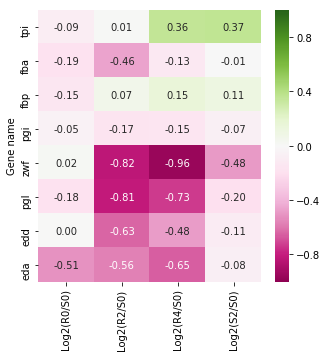

In [140]:
plt.cla()
plt.close()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

g=sns.heatmap(ED_gene_expression_df[['Log2(R0/S0)','Log2(R2/S0)','Log2(R4/S0)','Log2(S2/S0)']],
              vmin=-1,
              vmax=1,
              center=0,
              robust=True,
              cmap='PiYG',
              annot=True,
              fmt="2.2f")
fig.savefig('./output_data/gene_expression_ED_patahway.svg', format='svg', dpi=1200)

Gene expression ot TtgABC (orthologous of MexAB-OprM in Pseudomonas putida)

In [163]:
gene_id     = ['PP_1384', 'PP_1385', 'PP_1386']
gene_name   = ['ttgC',    'ttgB',    'ttgA']

TtgABC_gene_expression_df = []
for gid, gname in zip(gene_id,gene_name):
    log2_fc_S2_S0 = np.log2(rna_counts.loc[gid,'Sensitive_azt2'])
    log2_fc_R0_S0 = np.log2(rna_counts.loc[gid,'Resistant'])
    log2_fc_R2_S0 = np.log2(rna_counts.loc[gid,'Resistant_azt2'])                  
    log2_fc_R4_S0 = np.log2(rna_counts.loc[gid,'Resistant_azt4'])
        
    TtgABC_gene_expression_df.append({'Gene id' : gid,
                                      'Gene name' : gname,
                                      'Log2(S2/S0)':log2_fc_S2_S0, 
                                      'Log2(R0/S0)':log2_fc_R0_S0,
                                      'Log2(R2/S0)':log2_fc_R2_S0,
                                      'Log2(R4/S0)':log2_fc_R4_S0})

TtgABC_gene_expression_df = pd.DataFrame(TtgABC_gene_expression_df)
TtgABC_gene_expression_df.set_index('Gene name',inplace=True)
TtgABC_gene_expression_df

,Gene id,Log2(R0/S0),Log2(R2/S0),Log2(R4/S0),Log2(S2/S0)
Gene name,,,,,
ttgC,PP_1384,1.464602,1.202900,1.224831,-0.197115
ttgB,PP_1385,1.218887,0.965072,1.012372,-0.303635
ttgA,PP_1386,0.673125,0.460233,0.611688,-0.369341
